In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt 

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from pathlib import Path

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# reflect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [10]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

# Print the result
print(f"The most recent date in the dataset is: {recent_date.date}")

The most recent date in the dataset is: 2017-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(recent_date.date, "%Y-%m-%d")
print(last_date)

2017-08-23 00:00:00


In [14]:
first_date = last_date - dt.timedelta(days=365)
print(first_date)

2016-08-23 00:00:00


In [15]:
# Perform a query to retrieve the data and precipitation scores
last_year = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= first_date).all()

In [16]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(last_year, columns=["date", "prcp"])
prcp_df.set_index("date", inplace=True)

In [17]:
# Sort the dataframe by date
prcp_df.sort_values(by="date", inplace=True)
prcp_df.fillna(0.00, inplace=True)
print(prcp_df.head())

            prcp
date            
2016-08-24  0.08
2016-08-24  0.00
2016-08-24  2.15
2016-08-24  2.28
2016-08-24  2.15


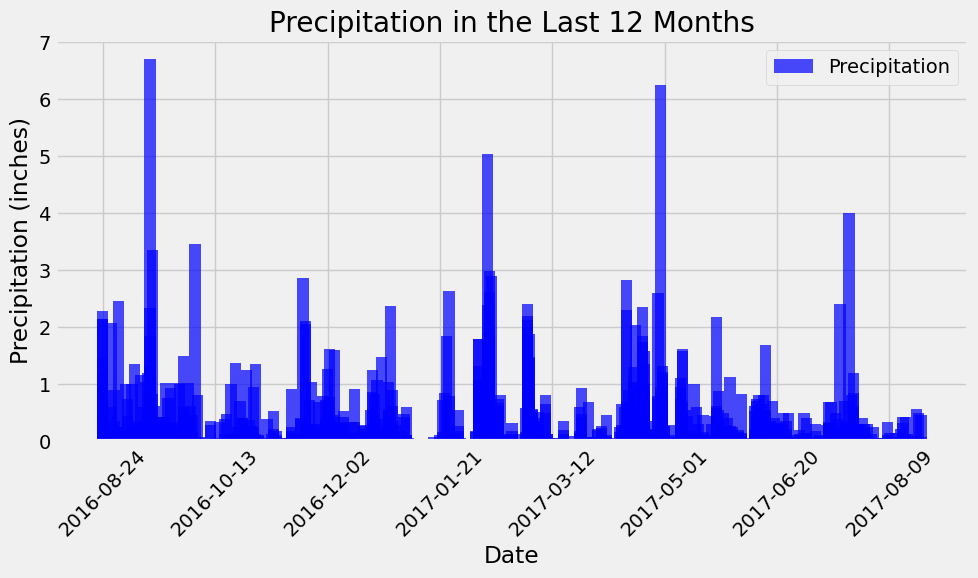

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(prcp_df.index, prcp_df["prcp"], width=5, label="Precipitation", color="b", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in the Last 12 Months")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.tight_layout()
plt.legend()
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df.describe()

print("Summary Statistics for Precipitation in the Last 12 Months:")
print(summary_stats)

Summary Statistics for Precipitation in the Last 12 Months:
              prcp
count  2223.000000
mean      0.159951
std       0.441220
min       0.000000
25%       0.000000
50%       0.010000
75%       0.110000
max       6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
station_total = session.query(station.station).count()
print(station_total)

9


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station {station}: {count} observations")

Most Active Stations:
Station USC00519281: 2772 observations
Station USC00519397: 2724 observations
Station USC00513117: 2709 observations
Station USC00519523: 2669 observations
Station USC00516128: 2612 observations
Station USC00514830: 2202 observations
Station USC00511918: 1979 observations
Station USC00517948: 1372 observations
Station USC00518838: 511 observations


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

print(temp_stats)

[(54.0, 85.0, 71.66378066378067)]


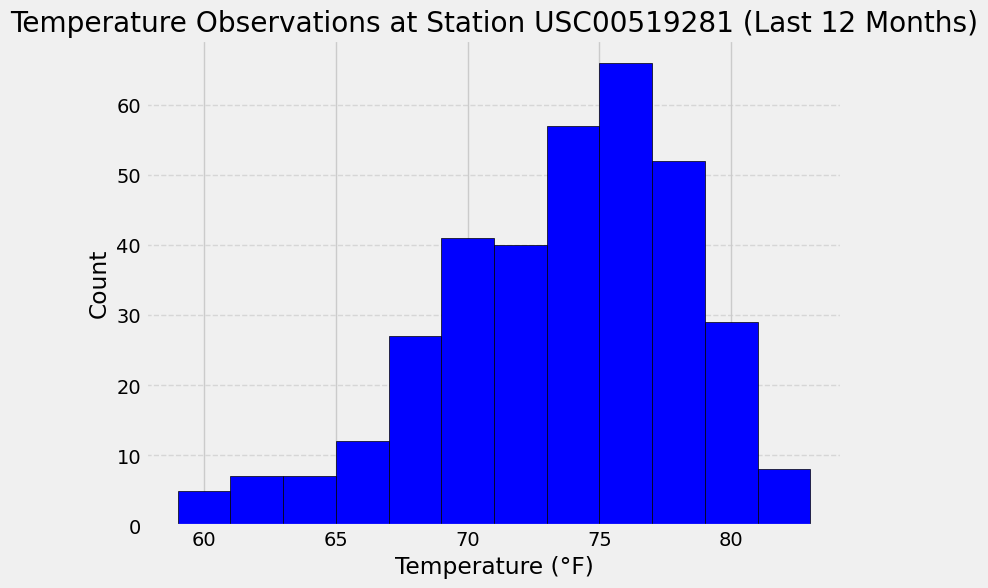

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_year_temperatures = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= first_date).all()

temperatures_list = [temp[0] for temp in past_year_temperatures]

plt.figure(figsize=(8, 6))
plt.hist(temperatures_list, bins=12, color='blue', edgecolor='black')
plt.xlabel("Temperature (°F)")
plt.ylabel("Count")
plt.title("Temperature Observations at Station USC00519281 (Last 12 Months)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Close Session

In [24]:
# Close Session
session.close()